In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import yaml
import os

In [53]:
## load configuration file
config = yaml.safe_load(open("config.yaml"))
root_path = os.getcwd()
print(config)

{'data_source': {'raw_file': 'E:\\01_Programming\\Py\\Aditya_MLPROCESS\\data\\00_raw\\credit_risk_dataset.csv', 'column_names': '', 'drop_columns': '', 'target_name': '', 'test_size': '', 'random_state': ''}}


**Below is an overview of dataset features**

```
# This is formatted as code
      Column                      #count          #type   # description
      -----------------------     --------------  ------  -----------------
 1.   person_age                  32416 non-null  int64   : Age

 2.   person_income               32416 non-null  int64   : Annual Income

 3.   person_home_ownership       32416 non-null  object  : Status of home ownership (cat)

 4.   person_emp_length           31529 non-null  float64 : Person employment length (years)

 5.   loan_intent                 32416 non-null  object  : Loan intention (Cat)

 6.   loan_grade                  32416 non-null  object  : Loan Grade (A-F)

 7.   loan_amnt                   32416 non-null  int64   : Loan amount (USD)

 8.   loan_int_rate               29321 non-null  float64 : Interest rate (%)

 9.   loan_status                 32416 non-null  int64   : 0-> non-default, 1-> default

 10.  loan_percent_income         32416 non-null  float64 : loan-income ratio (0-1)

 11.  cb_person_default_on_file   32416 non-null  object  : historical default (T / F)

 12.  cb_person_cred_hist_length  32416 non-null  int64   : credit history length (in years?)
```

In [54]:
## functions
def load_data(fname: pd.DataFrame):
    """
    load credit risk data and delete duplicates.
    functions also spew validation statement after dropping duplicates
    """
    data = pd.read_csv(fname)
    data_copy = deepcopy(data)
    data_copy.drop_duplicates(inplace=True)

    '''validation'''
    print(f"Data before dropping shape: {data.shape}")
    print(f"Data after dropping shape: {data_copy.shape}")

    return data

def percent_missing_values(dataframe):
    """
    Calculate the percentage of missing values in each column of a DataFrame.
    """
    missing_value_info = []  # List to store missing value information

    for col in dataframe.columns:
        # catch missing value type na, None and ""
        missing_values = dataframe[col].isna().sum() + \
                         dataframe[col].eq(None).sum() + \
                         (dataframe[col] == '').sum()

        # calculate percentage of missing per colum
        percentage_missing = (missing_values / len(dataframe)) * 100
        print(f"{round(percentage_missing, 2)}% missing values of {col}") ; print("")

def split_input_output(data, target_col):
  """
  :param DataFrame data: targeted DataFrame
  :param str target_col: collumns to be dropped
  """
  y = data[target_col]
  X = data.drop(target_col, axis=1)

  # print out data shape
  print(f"(X) Input shape: {X.shape}")
  print(f"(y) Output shape: {y.shape}")

  return X, y

def split_train_test(input, output, test_size, seed, stratify):

  from sklearn.model_selection import train_test_split

  # first batch Train and temp
  X_train, X_temp, y_train, y_temp = train_test_split(input, output,
                                                              test_size=test_size,
                                                              random_state=seed,
                                                              stratify=stratify)
  ## train ratio
  list_class_train = y_train.value_counts().to_list()
  ratio_train = list_class_train[1] / list_class_train[0]

    ## train ratio
  list_class_temp = y_temp.value_counts().to_list()
  ratio_temp = list_class_temp[1] / list_class_temp[0]

  return X_train, X_temp, y_train, y_temp, ratio_train, ratio_temp

In [55]:
fname = config['data_source']['raw_file']
data = load_data(fname)
data.head(5)

Data before dropping shape: (32581, 12)
Data after dropping shape: (32416, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Data preparation steps:

1. Insight on missing value
2. Class distribution
3. Split input

In [57]:
percent_missing_values(data)

0.0% missing values of person_age

0.0% missing values of person_income

0.0% missing values of person_home_ownership

2.75% missing values of person_emp_length

0.0% missing values of loan_intent

0.0% missing values of loan_grade

0.0% missing values of loan_amnt

9.56% missing values of loan_int_rate

0.0% missing values of loan_status

0.0% missing values of loan_percent_income

0.0% missing values of cb_person_default_on_file

0.0% missing values of cb_person_cred_hist_length



In [58]:
data.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

**Insights**

 -  There are some missing values in the feature `person_emp_length` and `loan_int_rate` both of which has a float variable. Therefore we have to consider imputation in numerical features.

 - There are no missing values for categorical features. Therefore, our pipeline only need encoding for these features.

Text(0.5, 1.0, 'Count of Class Instances with Minor-Major Ratio (0.28)')

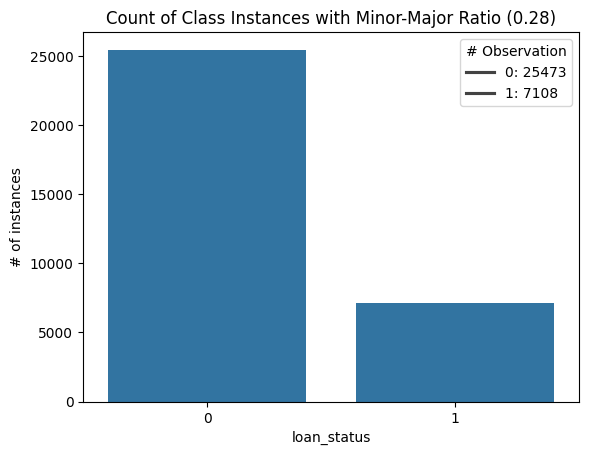

In [59]:
target_counts = data['loan_status'].value_counts()

sns.barplot(x=target_counts.index, y=target_counts.values)
ratio= []
labels = []

for i, count in zip(target_counts.index, target_counts.values):
    labels.append(f'{i}: {count}')
    num_str = labels[i][3:]
    num = int(num_str)
    ratio.append(num)

cls_ratio = round(min(ratio) / max(ratio), 2)
plt.legend(title="# Observation", labels=labels)
plt.ylabel("# of instances")
plt.title(f"Count of Class Instances with Minor-Major Ratio ({cls_ratio})")

1. Class distribution
2. Correlation of dependent and independent variables
3. Assigning data types